In [3]:
import os
from google.colab import drive

import pandas as pd
import matplotlib as mtp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [4]:
gdrive_dir = '/content/drive/'

drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/drive/


In [5]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/data/Data files'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/data/Data files/for_clustering.xlsx
/content/drive/MyDrive/Colab Notebooks/data/Data files/Customer_info.xlsx
/content/drive/MyDrive/Colab Notebooks/data/Data files/Transactions_info.xlsx
/content/drive/MyDrive/Colab Notebooks/data/Data files/Tableau_task_example.xlsx


In [6]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/Data files/for_clustering.xlsx')

In [7]:
data.head(5)

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,0.042788,1,1,22,3,557.97,1,1,1,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id_client                 27508 non-null  int64  
 1   InWeek_amount             27508 non-null  float64
 2   InWeek_SKU                27508 non-null  int64  
 3   Checkinmonth_average      27508 non-null  int64  
 4   Checkamount_mean          27508 non-null  float64
 5   Count_transac             27508 non-null  int64  
 6   Total_amount              27508 non-null  float64
 7   Total_SKU_qnt             27508 non-null  int64  
 8   Count_departments         27508 non-null  int64  
 9   Count_shop                27508 non-null  int64  
 10  Count_city                27508 non-null  int64  
 11  Tenure                    27508 non-null  int64  
 12  SKU_meanbytransac         27508 non-null  int64  
 13  Amount_last6mnth          27508 non-null  float64
 14  Check_

In [10]:
data[data.isna()].count()

Id_client                   0
InWeek_amount               0
InWeek_SKU                  0
Checkinmonth_average        0
Checkamount_mean            0
Count_transac               0
Total_amount                0
Total_SKU_qnt               0
Count_departments           0
Count_shop                  0
Count_city                  0
Tenure                      0
SKU_meanbytransac           0
Amount_last6mnth            0
Check_qntlast6mnth          0
SKU_price_mean              0
Gender                      0
Age                         0
Age_group                   0
Interval_visit              0
Days_pastvisit              0
Cat_householdchem_qnt       0
Cat_householdchem_amount    0
Cat_householdchem_share     0
Cat_careproducts_qnt        0
Cat_careproducts_amount     0
Cat_careproducts_share      0
Cat_toiletries_qnt          0
Cat_toiletries_amount       0
Cat_toiletries_share        0
Cat_healthwellnes_qnt       0
Cat_healthwellnes_amount    0
Cat_healthwellnes_share     0
Cat_babypr

In [11]:
data['Id_client'].duplicated().any()

False

In [12]:
data['Discount'].unique()

array([1, 0])

In [13]:
data.drop('Id_client', axis=1, inplace=True)

In [14]:
cat_feat = ['Gender',
            'Age_group',
            'Cat_householdchem_qnt',
            'Cat_householdchem_amount',
            'Cat_householdchem_share',
            'Cat_careproducts_qnt',
            'Cat_careproducts_amount',
            'Cat_careproducts_share',
            'Cat_toiletries_qnt',
            'Cat_toiletries_amount',
            'Cat_toiletries_share',
            'Cat_healthwellnes_qnt',
            'Cat_healthwellnes_amount',
            'Cat_healthwellnes_share',
            'Cat_babyprod_qnt',
            'Cat_babyprod_amount',
            'Cat_babyprod_share',
            'Discount',
            '_SEGMENT_',
            'EM_SEGMENT']

In [15]:
cat_data = pd.DataFrame(data, columns=cat_feat)
cons_data = data.drop(cat_feat, axis=1)

In [16]:
cat_data.head()

,Gender,Age_group,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Discount,_SEGMENT_,EM_SEGMENT
0,F,_x0033_5-45,175,2747.71,0.221616,278,3490.27,0.281507,420,4096.35,0.330391,161,1059.810,0.085479,80,1004.370,0.081007,1,2,2
1,F,_x0032_5-35,199,4097.59,0.316181,279,4027.09,0.310741,407,3303.69,0.254921,93,1054.805,0.081391,46,476.475,0.036766,1,2,2
2,F,_x0032_5-35,18,121.36,0.040946,62,2013.35,0.679295,39,159.50,0.053815,34,334.830,0.112970,17,334.840,0.112974,1,3,3
3,F,_x0034_5-55,798,5176.77,0.263096,500,5094.25,0.258902,995,7777.19,0.395256,129,1088.880,0.055340,64,539.250,0.027406,1,2,2
4,F,_x0032_5-35,59,639.32,0.257558,73,807.58,0.325343,90,264.95,0.106738,22,664.180,0.267573,11,106.210,0.042788,1,1,1


In [17]:
cat_data.describe()

,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Discount,_SEGMENT_,EM_SEGMENT
count,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000
mean,153.123346,2212.690888,0.230468,206.294569,3193.837092,0.326968,311.619056,2905.685814,0.307797,62.303475,725.944267,0.076154,30.901847,557.603120,0.058614,0.998073,2.002836,2.002836
std,109.706269,1386.636725,0.085635,137.099159,2019.471803,0.114520,246.678994,1844.887500,0.123203,49.729726,586.075099,0.048594,24.865939,557.239232,0.048882,0.043853,0.776181,0.776181
min,1.000000,9.270000,0.002708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,76.000000,1192.252500,0.171995,105.000000,1676.410000,0.248302,142.000000,1581.217500,0.221140,29.000000,303.958750,0.041349,14.000000,168.867500,0.022734,1.000000,1.000000,1.000000
50%,127.000000,1926.945000,0.223681,177.000000,2771.710000,0.319790,246.000000,2499.825000,0.291659,50.000000,570.345000,0.067024,25.000000,390.972500,0.047616,1.000000,2.000000,2.000000
75%,200.000000,2940.015000,0.279677,276.000000,4304.200000,0.397748,412.000000,3770.692500,0.376667,82.000000,979.432500,0.100419,41.000000,762.786250,0.081647,1.000000,3.000000,3.000000
max,1655.000000,17358.700000,0.845538,1293.000000,14445.530000,0.966703,4548.000000,17539.200000,0.986493,987.000000,6821.535000,0.535386,493.000000,15474.645100,0.887302,1.000000,3.000000,3.000000


In [18]:
cons_data.head()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,...,SKU_price_mean,Age,Interval_visit,Days_pastvisit,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount_LastMonth
0,269.5328,46,2,102.9252,119,12398.51,1114,26,4,1,...,10.360064,37.0,11,3,1,1,60,12,963.01,1
1,359.9902,36,4,100.2813,130,12959.65,1024,29,3,1,...,12.088369,29.0,11,2,1,0,91,15,1534.69,1
2,329.3200,9,4,102.2027,29,2963.88,170,24,1,1,...,15.591491,33.0,29,8,1,1,13,2,1514.48,1
3,385.8105,51,8,48.8550,404,19676.34,2486,33,3,1,...,7.703276,50.0,11,0,1,0,68,35,1872.24,1
4,310.2800,8,4,108.5789,25,2482.24,255,26,2,1,...,9.278015,33.0,14,8,1,1,22,3,557.97,1


In [19]:
cons_data.describe()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,...,SKU_price_mean,Age,Interval_visit,Days_pastvisit,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount_LastMonth
count,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,...,27508.000000,27356.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000
mean,314.792325,31.457212,2.565363,159.516226,82.467500,9595.761182,764.242293,26.742911,3.858550,1.079613,...,13.233163,43.024492,16.040461,5.291915,0.999964,0.547368,40.344009,8.395158,936.135833,0.920823
std,144.491147,11.379580,1.205160,111.533576,63.241479,4715.290935,451.728512,4.038126,2.757808,0.295729,...,4.984101,14.269920,6.420182,4.548674,0.006029,0.497760,23.765321,7.217166,590.934045,0.270020
min,34.474000,2.000000,2.000000,10.239800,4.000000,739.360000,33.000000,7.000000,1.000000,1.000000,...,2.042535,0.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1.000000,99.000000,0.000000
25%,213.042000,23.000000,2.000000,85.728675,39.000000,5897.177500,433.000000,24.000000,2.000000,1.000000,...,9.903953,32.000000,12.000000,2.000000,1.000000,0.000000,22.000000,3.000000,446.880000,1.000000
50%,289.220350,31.000000,2.000000,128.752500,66.000000,8820.700000,674.000000,27.000000,3.000000,1.000000,...,12.426685,41.000000,13.000000,4.000000,1.000000,1.000000,37.000000,6.000000,825.895000,1.000000
75%,385.379300,41.000000,2.000000,199.252325,108.000000,12631.300000,1003.000000,30.000000,5.000000,1.000000,...,15.572424,54.000000,18.000000,7.000000,1.000000,1.000000,55.000000,11.000000,1329.787500,1.000000
max,2180.013700,51.000000,20.000000,1326.115700,990.000000,22748.390000,5058.000000,38.000000,46.000000,9.000000,...,109.288938,94.000000,41.000000,32.000000,1.000000,1.000000,180.000000,112.000000,2478.470000,1.000000


Анализируя типы данных набора данных, невозможно заметить повторение какого-либо конкретного типа потребителя или наличие отсутствующих данных.

Можно увидеть что некоторые признаки имеют тип Object: Gender и Age_group

In [20]:
data['Gender'].unique()

array(['F', 'M', nan], dtype=object)

In [21]:
data['Age_group'].unique()

array(['_x0033_5-45', '_x0032_5-35', '_x0034_5-55', '_x0036_5_x002B_',
       '_x0035_5-65', '_x0030_-25', nan], dtype=object)

У признака Age_group видимо ошибка в кодировке названия произошла

In [22]:
data['Age_group'] = data['Age_group'].map({'_x0030_-25':0, 
                                           '_x0032_5-35':1,
                                           '_x0033_5-45':2,
                                           '_x0034_5-55':3, 
                                           '_x0035_5-65':4,
                                           '_x0036_5_x002B_':5})

'_x0030_-25' - это возраст от 0-25 лет<br> '_x0032_5-35' - это возраст от 25-35 лет<br> '_x0033_5-45' - это возраст от 35-45 лет<br> '_x0034_5-55' - это возраст от 45-55 лет<br> '_x0035_5-65' - это возраст от 55-65 лет<br> '_x0036_5_x002B_' - это возраст от 65 лет

In [23]:
data['Gender'] = data['Gender'].map({'F':0, 'M':1})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   InWeek_amount             27508 non-null  float64
 1   InWeek_SKU                27508 non-null  int64  
 2   Checkinmonth_average      27508 non-null  int64  
 3   Checkamount_mean          27508 non-null  float64
 4   Count_transac             27508 non-null  int64  
 5   Total_amount              27508 non-null  float64
 6   Total_SKU_qnt             27508 non-null  int64  
 7   Count_departments         27508 non-null  int64  
 8   Count_shop                27508 non-null  int64  
 9   Count_city                27508 non-null  int64  
 10  Tenure                    27508 non-null  int64  
 11  SKU_meanbytransac         27508 non-null  int64  
 12  Amount_last6mnth          27508 non-null  float64
 13  Check_qntlast6mnth        27508 non-null  int64  
 14  SKU_pr

Корреляция — это статистическая мера, которая объясняет, как одна или несколько переменных связаны друг с другом. Эти переменные могут быть функциями входных данных, которые использовались для прогнозирования нашей целевой переменной.

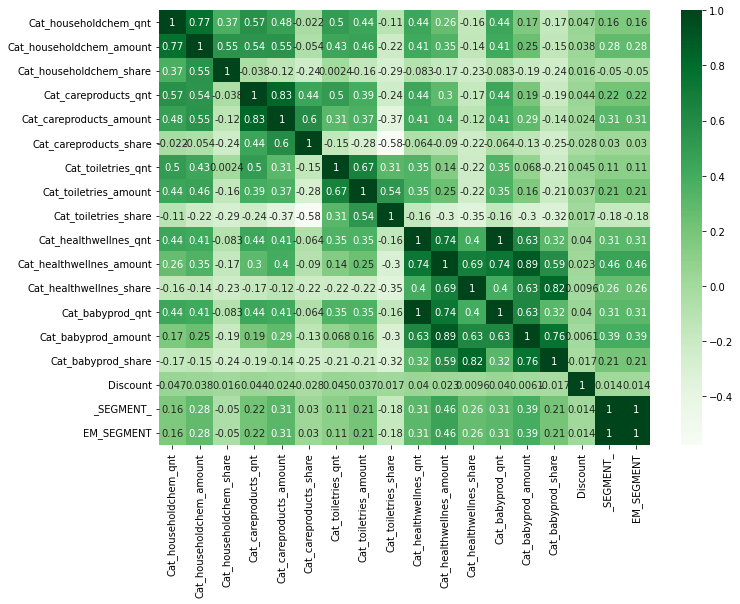

In [24]:
corr = cat_data.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

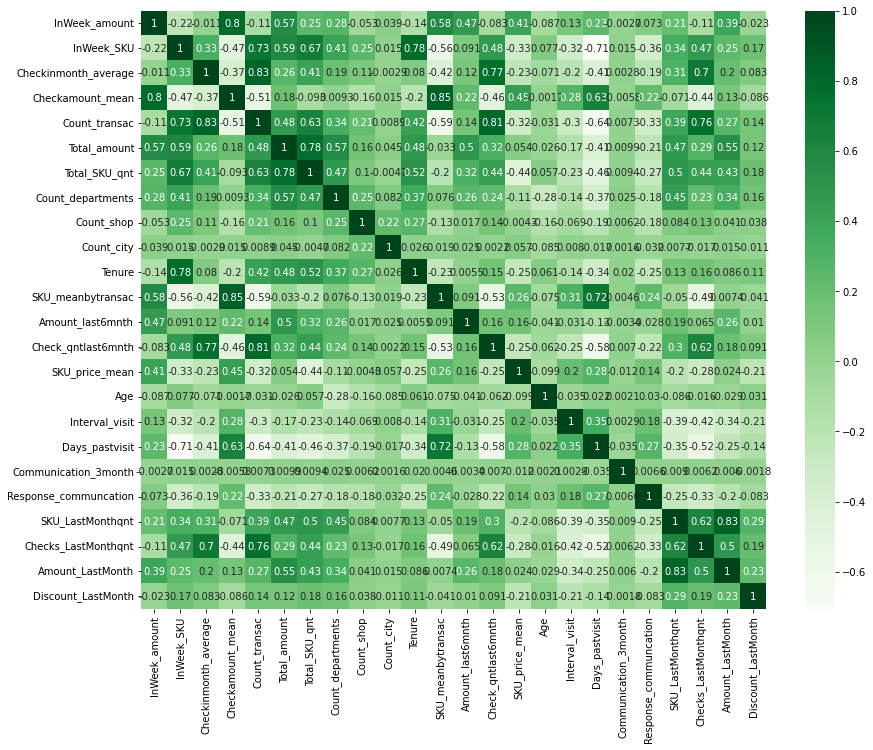

In [25]:
corr = cons_data.corr()
plt.figure(figsize=(14,11))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

Как можно видеть по хитмапам в таблице есть такие признаки, у которых выскокая корреляция, но сильнее всего отличаются _SEGMENT_ и EM_SEGMENT, Cat_babyprod_qnt и Cat_healthwellnes_qnt, у которых кореляция состовляет 1. Это означает что эти признаки коллинеарны.

# Feature Engerring


Проверка корреляции между переменными важна для задачи мультиколлинеарности между переменными

Мультиколлинеарность возникает, когда модель включает несколько факторов, которые коррелируют не только со своей переменной отклика, но и друг с другом, увеличивая стандартные ошибки коэффициентов, превращая переменную, которая могла бы быть полезной, в пренебрежимо малую.

Поэтому можно избавиться от одного признака от каждой пары

In [26]:
data = data.drop(['EM_SEGMENT','Cat_healthwellnes_qnt'], axis=1)

Поскольку целью является разработка целевых групп клиентов, для определения этих групп будет использоваться модель кластеризации через модель К-средних.

Поскольку это модель кластеризации, основанная на евклидовых расстояниях, данные должны быть масштабированы таким образом, чтобы используемая модель имела большую точность при создании групп.

In [27]:
imp = SimpleImputer(strategy="most_frequent")
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaler = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_scaler = imp.fit_transform(data_scaler)
data_scaler

array([[0.10955696, 0.89795918, 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.15171763, 0.69387755, 0.11111111, ..., 1.        , 1.        ,
        0.5       ],
       [0.13742277, 0.14285714, 0.11111111, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.23131485, 0.2244898 , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.15845221, 0.42857143, 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.07259605, 0.30612245, 0.        , ..., 1.        , 1.        ,
        0.        ]])

# Реализация модели

## K-means

Для реализации модели k-средних необходимо изначально выбрать количество генерируемых групп. Для этого будут использоваться четыре различных критерия для определения количества кластеров, которые необходимо создать. Речь идет о следующих критериях:<br><br>
The Elbow method, based in inertia.<br>
Silhouette criterion.<br>
Calinski and Harabasz criterion.<br>
Davies and Bouldin criterion.

In [28]:
wcss = []
sil = []
CeH = []
DeB = []
for i in range(2,21):
    kmeans_trib = KMeans(n_clusters = i, random_state = 0)
    kmeans_trib.fit(data_scaler)
    aux1 = silhouette_score(data_scaler, kmeans_trib.labels_)
    aux2 = calinski_harabasz_score(data_scaler, kmeans_trib.labels_)
    aux3 = davies_bouldin_score(data_scaler, kmeans_trib.labels_)
    wcss.append(kmeans_trib.inertia_)
    sil.append(aux1)
    CeH.append(aux2)
    DeB.append(aux3)

In [30]:
figu = make_subplots(rows = 2, cols = 2,subplot_titles=("Inércia", "Silhouette", "Calinski and Harabasz", "Davies and Bouldin"))
X = np.arange(2,21)
figu.add_trace(
    go.Scatter(x = X, y = wcss,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=1)
figu.add_trace(
    go.Scatter(x = X, y = sil,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=2)
figu.add_trace(
    go.Scatter(x = X, y = CeH,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=1)
figu.add_trace(
    go.Scatter(x = X, y = DeB,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=2)

figu.update_xaxes(title_text="Nº clusters", row=1, col=1)
figu.update_xaxes(title_text="Nº clusters", row=1, col=2)
figu.update_xaxes(title_text="Nº clusters", row=2, col=1)
figu.update_xaxes(title_text="Nº clusters", row=2, col=2)

figu.update_yaxes(title_text="Score", row=1, col=1)
figu.update_yaxes(title_text="Score", row=1, col=2)
figu.update_yaxes(title_text="Score", row=2, col=1)
figu.update_yaxes(title_text="Score", row=2, col=2)
figu.update_layout(showlegend=False,height=1000, width=1000)
figu.show()

Глядя на графики, имеем:

Для критерия Inércia точка перегиба приходится на число кластеров, равное 5. <br>
Для критерия Silhouette точка с наивысшим баллом — это точка с 6 кластерами. <br>
Для критерия Calinski and Harabasz первая положительная точка перегиба возникает при количестве кластеров, равном 5. <br>
Согласно критерию Davies and Bouldin, точка с наименьшим баллом — это точка с 4 кластерами. <br>
Кроме этого можно заметить что 5 кластеров также отличились на графиках критерии Silhouette и Davies and Bouldin<br><br>
Я считаю, что наименьшее количество сформированных групп, которая показывает лучшие результаты в большинства метриках лучше всего подходит для первоначального анализа. Следовательно, для остальных анализов будет использоваться 5 кластеров.

# Визуализация кластера — PCA

Для визуализация нам потребуется 2 или 3 измерения

Поскольку анализируемый набор данных имеет 42 измерений (42 признаков), визуализация этих данных становится сложной и невозможной для применения. Чтобы визуализировать сформированные кластеры, необходимо применять методы уменьшения размера этих данных, чтобы можно было визуализировать кластеры без потери информации.

Одним из таких методов уменьшения размерности является анализ основных компонентов (PCA), который является очень популярным методом уменьшения размерности для визуализации кластера. Это неконтролируемый метод машинного обучения, который пытается получить набор низкоразмерных наборов функций из гораздо большего набора, сохраняя при этом максимально возможную дисперсию.

In [33]:
pca = PCA()
pca_components = pca.fit(data_scaler)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var_cumulative = np.zeros(len(var))
var_cumulative[0] = var[0]
for i in range(1,len(var)):
    var_cumulative[i] = var[i]+var_cumulative[i-1]

labels = [
    f"PC {i+1}"
    for i in range(0,len(var))
]

fig = go.Figure()
fig.add_trace(go.Bar(
    x = labels,
    y= var,
    text = var,
    name='Individual contribution'))

fig.add_trace(go.Bar(
    x = labels,
    y = var_cumulative,
    text = var_cumulative,
    name ='Cumulative contribution'))

fig.update_layout(barmode='group',
                  title="PCA Explained contribution",
                  xaxis_title="Components",
                  yaxis_title="Value of Contribution")

fig.show()

Наблюдая за графиком, можно отметить, что объяснимость данных с тремя компонентами составляет 56,1%, что является значением, которое я считаю достаточно разумным для визуализации данных.

Но она конечно будет недостаточно точной.

In [34]:
kmeans_trib = KMeans(n_clusters = 5, random_state = 0)
kmeans_trib.fit(data_scaler)
data['class'] = kmeans_trib.labels_
for i in range(0,max(kmeans_trib.labels_)+1):
    var = 'class '+ str(i+1)
    data['class'] = data['class'].replace(i,var)

In [35]:
pca = PCA(3)
pca_components=pca.fit(data_scaler)
scores_pca = pca.transform(data_scaler)
pca_data = pd.DataFrame(scores_pca, columns=['PC 1','PC 2','PC 3']) 
pca_data['class'] = data['class']

fig = px.scatter_3d(pca_data,x = 'PC 1', y = 'PC 2', z = 'PC 3' ,color='class',width=1200,height = 600, labels={"class":"Classified class"})
fig.show()

Анализируя сгенерированный граф, классы 1(фиолетовый), 2(красный), 3(синий) и 5(оранжевый) хорошо изолированы и могут представлять разные группы целевых клиентов.

Для классов 4(зеленый) и 3(синий), визуализируя их, они очень близки, что необходимо проверить, действительно ли эти группы имеют разные характеристики между собой. Та же проблема возникает с классами 4(зеленый) и 2(красный).

In [36]:
data_view = data.copy()

In [37]:
cond = (data_view['class']== 'class 3') | (data_view['class']== 'class 4')
dat_view = data_view.loc[cond].copy()
fig = px.scatter_matrix(dat_view,dimensions=["Checkamount_mean","Age","Count_city","InWeek_amount","Discount","Gender","_SEGMENT_"], color ="class")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

При изучении графиков «InWeek_amount» видна разница между двумя группами, а при просмотре графиков «_SEGMENT_» между ними есть разделение.

In [38]:
fig = px.box(dat_view, x="InWeek_amount", y ="_SEGMENT_",points="all",color='class', width=1200, height=600)
fig.show()

In [39]:
cond = (data_view['class']== 'class 1') | (data_view['class']== 'class 5')
dat_view2 = data_view.loc[cond].copy()
fig = px.scatter_matrix(dat_view2,dimensions=["Total_SKU_qnt","Age","Tenure","Total_amount","Discount","Gender","Count_city"], color ="class")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

Анализируя графики, мы видим, что классы 1 и 5 охватывают часть данных одного пола и возраста.

Изучая графики «Count_city», «Total_SKU_qnt» можно увидеть разницу между двумя группами.

In [40]:
fig = px.box(dat_view2, x="Count_city", y ="Total_SKU_qnt",points="all",color='class', width=1200, height=600)
fig.show()

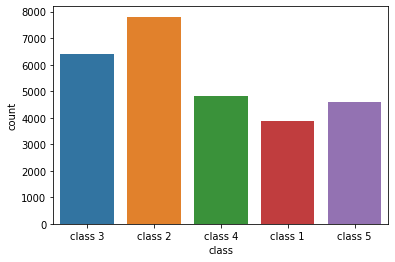

In [41]:
sns.countplot(data= data, x = 'class')

In [42]:
fig = px.box(data_view, x="_SEGMENT_", y ="Interval_visit",points="all",color='class', width=1200, height=600)
fig.show()

In [43]:
fig = px.box(data_view, x="Gender", y ="InWeek_amount",points="all",color='class', width=1200, height=600)
fig.show()

# Вывод

In [44]:
data.groupby('class').mean()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,...,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_
class,,,,,,,,,,,,,,,,,,,,,
class 1,312.519797,35.269231,2.869902,134.558672,105.905008,10833.441846,860.137068,27.101704,4.761487,1.121064,...,517.345213,0.048484,0.999742,0.000000,43.328859,10.881002,1063.422463,0.999742,0.927723,1.993547
class 2,303.788839,37.807402,2.871815,128.102922,112.417083,11223.292470,967.815597,28.178896,4.264054,1.077731,...,625.619372,0.054920,1.000000,0.000000,51.548342,11.822897,1139.137284,0.999744,0.975285,2.156486
class 3,364.940350,30.239731,2.469155,198.215293,73.182102,10492.894860,793.384351,27.701234,3.517570,1.065126,...,700.029129,0.067157,1.000000,1.000000,47.169920,8.063876,1130.795674,0.998594,0.960019,2.620022
class 4,247.287353,23.796135,2.135079,154.370102,45.424148,5546.267926,452.934539,23.914173,3.089568,1.055071,...,352.529204,0.063612,1.000000,0.840399,18.097049,3.372195,339.994462,0.996052,0.812552,1.003325
class 5,336.151569,27.184816,2.373102,185.322098,63.602820,8779.632742,623.291323,25.630586,3.689154,1.093709,...,492.458256,0.056301,1.000000,1.000000,32.597397,6.203037,837.194095,0.995228,0.881345,1.936443


Кластеры <br>
1 это активные мужчины, которые давно пользуются услугой<br>
2 это активные женщины, которые давно пользуются услугой, меньшинство<br>
3 это женщины, среднестатистические<br>
4 это довольно взрослые женщины, которые редко пользуются, из 1 сегмента и самые неактивные.<br>
5 это не особо активные мужчины, которые причем большинство